# Receiver Operating Characteristic (ROC) Curve.<br>Крива Робочої Характеристики Приймача

ROC-крива &mdash; один із методів оцінки якості натренованих __бінарних класифікаторів__, тобто тих, що працють з двома мітками: "1" (істина) та "0" (хиба). Крива зображується в двовимірному просторі:
* По осі $OX$ &mdash; __False Positive Rate (FPR)__ &mdash; частка семплів із міткою "0", що були _некоректно_ класифіковані як істинні;
* По осі $OY$ &mdash; __True Positive Rate (TPR)__ &mdash; частка семплів із міткою "1", що були _коректно_ класифіковані як істинні.

Більш формально, 
$$ \text{ False Positive Rate } = \frac{ FP }{ N } = \frac{ FP }{ FP + TN }, $$
$$ \text{ True Positive Rate }  = \frac{ TP }{ P } = \frac{ TP }{ TP + FN }, $$
де
* $P$ (Positive) &mdash; сукупна кількість семплів із міткою "1";
* $N$ (Negative) &mdash; сукупна кількість семплів із міткою "0";
* $TP$ (True Positive) &mdash; кількість семплів із міткою "1", що були коректно класифіковані як "1";
* $TN$ (True Negative) &mdash; кількість семплів із міткою "0", що були класифіковані як "0";
* $FP$ (False Positive __помилка першого роду__) &mdash; кількість семплів із міткою "0", що були некоректно класифіковані як "1";
* $FN$ (False Negative, __помилка другого роду__) &mdash; кількість семплів із міткою "1", що були некоректно класифіковані як "0".

Побудова ROC-кривої доцільна для класифікаторів, що можна описати наступним правилом:

$$\hat{y}_i = \mathbb{I} \left[ p(\mathbf{x}_i) \geq t \right],$$

тобто, класифікатор видає ймовірність належності семплу $\mathbf{x}_i$ класу "1", і якщо ця ймовірність вища за заданий поріг $t$, то об'єкту призначається мітка "1", інакше &mdash; "0". 

У `scikit-learn` такі класифікатори мають метод `predict_proba(X)`. 

Крива будується наступним чином: для кожного значення порогу $t\in [0; 1]$ рахуються $FPR$ та $TPR$ на тестовому наборі даних та відкладаються за відповіднми осями. Помітимо, що при $t=1$ усі об'єкти будуть класифіковані як хибні, тому $FP = TP = 0$ і обидва показники дорівнюватимуть 0; а при $t=0$ усі семпли будуть класифіковані як істинні, тож $TN = FN = 0$ і обидва показники дорівнюватимуть 1. Тобто, крива ROC завжди проходить через точки $(0; 0)$ та $(1; 1)$.

__Як за домопогою кривої візуально оцінити якість класифікатора?__

<hr color="red">

* В найкращому випадку, коли класифікатор коректно визначає мітки всех об'єктів, на графіку буде точка $(0, 1$), і ROC-крива матиме вигляд $y = 1$;

* Якщо ROC-крива близька до 1, тобто $y \approx 1$ (додатна кривизна, крива опукла вгору), то наш класифікатор має високу точність;

* Якщо крива близько $y \approx x$, тобто крива має ступінчастий вигляд біля бісектриси, то якість класифікатора не більше, ніж сліпе вгадування чи підкидання монетки;

* В найгіршому випадку отримаємо $y \approx 0$ (від'ємна кривизна, крива випукла вниз). Це означає, що ми класифікували об'єкти з точністю до навпаки.
<hr color="red">

Спершу побудуємо криву вбудованими засобами бібліотеки для деякого набору даних, а потім детальніше розглянемо механіку побудови для маленького штучного датасету.


## ROC-крива у `scikit-learn`

In [ ]:
import numpy as np

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [ ]:
# Деякий класифікатор для прикладу
X, y = make_classification(n_samples=1000)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, stratify=y)
clf = LogisticRegression(solver='lbfgs').fit(X_train, y_train)
y_pred_proba = clf.predict_proba(X_test)[:, 1]

In [ ]:
import matplotlib
font = {'size': 14}
matplotlib.rc('font', **font)

import matplotlib.pyplot as plt
from sklearn.preprocessing import Binarizer
from sklearn.metrics import auc, roc_curve

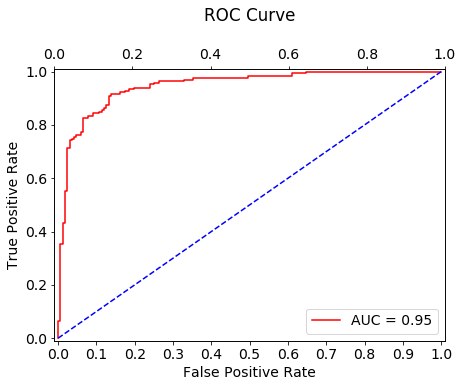

In [ ]:
# Функція для побудови ROC кривої вбудованими методами
def plot_roc(y_test, y_pred_proba):

  fig = plt.figure(figsize=(7, 5))
  values = []
  ax1 = fig.add_subplot(111)
  ax2 = ax1.twiny()

  fpr, tpr, ths = roc_curve(y_test, y_pred_proba)
  auc_val = auc(fpr, tpr)
  ax1.plot(fpr, tpr, color="red", label="AUC = {0:.2f}".format(auc_val))
  ax1.set_xlabel("False Positive Rate")
  ax1.set_ylabel("True Positive Rate")
  plt.title("ROC Curve\n")
  ax1.set_xlim((-0.01, 1.01))
  ax1.set_ylim((-0.01, 1.01))
  ax1.set_xticks(np.linspace(0, 1, 11))
  ax1.plot([0, 1], [0, 1], color="blue", linestyle='--')
  ax1.legend(loc="lower right")
  plt.show()

plot_roc(y_test, y_pred_proba)

## Побудова ROC-кривої руками

__Розглянемо приклад__.

Нехай у нас є $n = 4$ об'єкта, що належать класу `"0"`, та $m = 3$ об'єкта, що належать класу `"1"`.

Відповіді класифікатора наведено у `таблиці 1`



<hr>

_Таблиция 1_ -- Результат бінарної класицікації деяким алгоритмом 7-ми об'єктів

|  id  | Score | Class |
| :--: | :---------: | :---: |
| 1 | 0.5 | 0 |
| 2 | 0.1 | 0 |
| 3 | 0.2 | 0 |
| 4 | 0.6 | 1 |
| 5 | 0.2 | 1 |
| 6 | 0.8 | 1 |
| 7 | 0.0 | 0 |

In [ ]:
ex_y_true = [0, 0, 0, 1, 1, 1, 0]
ex_y_pred_proba = [0.5, 0.1, 0.2, 0.6, 0.2, 0.8, 0.0]

<hr color="red">

Нехай алгоритм видав оцінки, як показано у `таблиці 1`. Впорядкуємо рядки `таблиці 1` за спаданням відповідей алгоритму, отримаємо `таблицю 2`. Ясно, що в ідеалі, стовпець "клас" також буде впорядкованим (спочатку будуть `"1"`, а потім `"0"`). В найгіршому випадку -- порядок буде обернений. Для сліпого вгадування буде випадковий розподіл `"0"` та `"1"`

<hr color="red">

_`Таблиция 2`_ -- Ранжований результат класифікації за ймовірностями

|  id  | Score | Class |
| :--: | :---------: | :---: |
| 6 | 0.8 | 1 |
| 4 | 0.6 | 1 |
| 1 | 0.5 | 0 |
| 3 | 0.3 | 0 |
| 5 | 0.2 | 1 |
| 2 | 0.1 | 0 |
| 7 | 0.0 | 0 |

In [ ]:
tp = 2
tn = 3
fp = 1
fn = 1
tpr = tp/(tp + fn)
fpr = fp/(fp + tn)
print(f"TPR = {tpr}, FPR = {fpr}")

TPR = 0.6666666666666666, FPR = 0.25


<hr>

_`Таблиция 3`_ -- Ранжований результат класифікації з мітками

|  id  | Score >= 0.5 | Class | ? |
| :--: | :---------: | :---: | :-: |
| 6 | 1 | 1 | TP |
| 4 | 1 | 1 | TP |
| 1 | 1 | 0 | FP |
| 3 | 0 | 0 | TN |
| 5 | 0 | 1 | FN |
| 2 | 0 | 0 | TN |
| 7 | 0 | 0 | TN |

Для того, щоб побудувати ROC криву, необхідно взяти одиничний квадрат на координтаній площині. Розбити його на $m$ горизонтальних частин та на $n$ -- вертикальних. В результаті, отримаємо сітку $n \times m$. В нашому прикладі: $n = 4$, $m = 3$

### Принцип побудову  кривої

Тепер будемо розглядати рядки `таблиці 2` або `3` зверху вниз та будувати на сітці лінії, переходячи від одного вузла в інший. Починаємо з точки $(0, 0)$. Якщо значення мітки класа в розглядаємому рядку -- 1, то _робимо крок верх_; якщо 0, то _робимо крок праворуч_. Очевидно, що в результаті ми потрапимо в чтоку $(1, 1)$, оскільки виконаємо в сумі $m$ кроків уверх та $n$ праворуч.

In [ ]:
points_00 = [
  [0, 0],
  [0, 1/3],
  [0, 2/3],
  [1/4, 2/3],
  [2/4, 2/3],
  [2/4, 1.0],
  [3/4, 1.0],
  [1.0, 1.0]
]

In [ ]:
# Функція для побудови заданої ламаної за заданими точками та кількостями класів
# n -- кількість об'єктів у класі "0"
# m -- кількість об'єктів у класі "1"
def plot_list_points_roc(points, n, m):
  
  # Транспонуємо список списків, щоб розділити точки по Оx та Оy
  points = list(map(list, zip(*points)))
  x = points[0]
  y = points[1]

  fig = plt.figure()
  ax = fig.add_subplot(1, 1, 1)

  # Пунктирна лінія y = x
  plt.plot([0, 1], [0, 1], linestyle='--', color='blue')
  # ROC крива побудована на заданих точках, з'єднаних лінією
  plt.plot(x, y, linestyle='-', marker='o', color='red')
  # Назви осей
  plt.xlabel('FPR')
  plt.ylabel('TPR')

  # Додаємо сітку
  grid_x_ticks = np.arange(-0.0001, 1.0001, 1/n)
  grid_y_ticks = np.arange(-0.0001, 1.0001, 1/m)
  ax.set_xticks(grid_x_ticks , minor=True)
  ax.set_yticks(grid_y_ticks , minor=True)
  ax.grid(which='minor')

  plt.show()

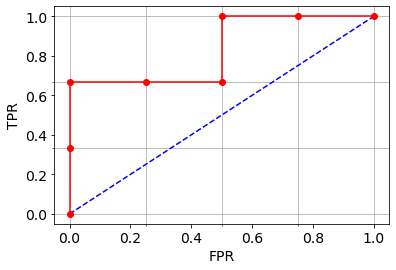

In [ ]:
plot_list_points_roc(points_00, 4, 3)

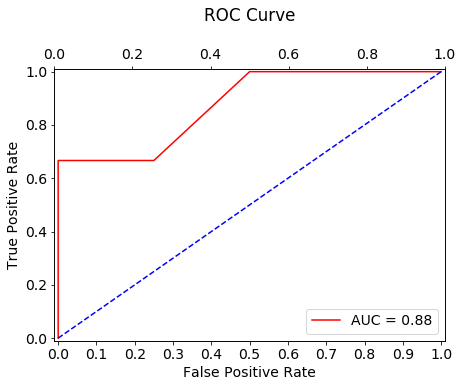

In [ ]:
plot_roc(ex_y_true, ex_y_pred_proba)

### Примітка

Якщо ви зробили одразу крок праворуч та вверх, то малюємо діагональ клітинки

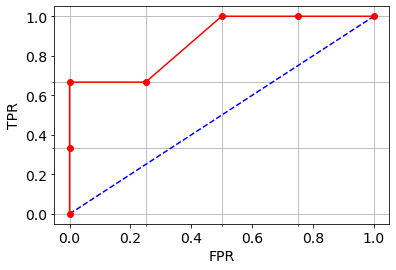

In [ ]:
points_01 = [
  [0, 0],
  [0, 1/3],
  [0, 2/3],
  [1/4, 2/3],
  [2/4, 1.0],
  [3/4, 1.0],
  [1.0, 1.0]
]

plot_list_points_roc(points_01, 4, 3)

In [ ]:
# Площа під кривою:
# Кількість клітинок під кривою / Кількість усіх клітинок
area_under_curve = 10.5/12
area_under_curve

0.875

# Показник AUC ROC

__AUC ROC__ -- показник, який відображає якість класифікатора, приймає значення в діапазоні від `0` до `1`. На практиці показує площу під кривою помилок (ROC curve). Якщо крива помилок відповідатиме лінії $y = 1$, то це означає, що ми правильно класифікували кожний об'єкт, тобто, в нас немає помилок.

Чим ближчий показник до одиниці, тим кращій класифікатор

In [ ]:
fpr, tpr, ths = roc_curve(y_test, y_pred_proba)
auc_val = auc(fpr, tpr)
print("AUC ROC =", auc_val)

AUC ROC = 0.9462512101545412


## Розрахунок показника AUC ROC

__AUC ROC__ дорівнює долі пар об'єктів виду (об'єкт класу `"1"`, об'єкт класу `"0"`), які алгоритм вірно впорядкував. Тобто перший об'єкт йде в упорядкованому списку раніше. Чисельно це можна записати так

<br>

$$ \frac{\sum_{i=1}^{N} \sum_{j=1}^{N} I(y_i < y_j) \cdot I'(a_i < a_j)}{\sum_{i=1}^{N} \sum_{j=1}^{N} I(y_i < y_j)}$$

<br>

- $N$ -- кількість об'єктів у тестовій виборці
- $y_i$ -- мітка, клас $i$-того об'єкта $\in \{0, 1\}$
- $a_i$ -- відповідь алгоритма на $i$-тому об'єкті, _ймовірність_, що $i$-тий об'єкт належить до класу `"1"`

<br>

\begin{equation*}
I(y_i < y_j) = 
 \begin{cases}
   0, &\text{$y_i \geq y_j$,}\\
   1, &\text{$y_i < y_j$.}
 \end{cases}
\end{equation*}

<br>

\begin{equation*}
I'(a_i < a_j) = 
 \begin{cases}
   0, &\text{$a_i > a_j$,}\\
   0.5, &\text{$a_i = a_j$,}\\
   1, &\text{$a_i < a_j$.}
 \end{cases}
\end{equation*}

In [ ]:
# Ручний підрахунок AUC ROC
def roc_auc_score(y_true, y_pred_proba):

  # Оператор I
  def I(yi, yj):
    return 0 if yi >= yj else 1

  # Оператор I'
  def II(ai, aj):
    return 0 if ai > aj else 0.5 if ai == aj else 1

  n = len(y_true)
  
  nominator = 0
  denominator = 0
  
  # Подвійна сума
  for i in range(n):
    for j in range(n):
      real = I(y_true[i], y_true[j])
      algorithm = II(y_pred_proba[i], y_pred_proba[j])
      # Розрахунок подвійної суми в чисельнику за формлою (*)
      nominator += real*algorithm
      # Розрахунок подвійної суми в знаменнику за формлою (*)
      denominator += real

  return nominator/denominator

### Розрахунок показника AUC ROC для прикладу з класифікатором

In [ ]:
score = roc_auc_score(y_test, y_pred_proba)
print(f"AUC ROC = {score}")

AUC ROC = 0.9462512101545412


### Розрахунок показника AUC ROC для прикладу з 7 об'єктами

In [ ]:
score = roc_auc_score(ex_y_true, ex_y_pred_proba)
print(f"AUC ROC = {score}")

AUC ROC = 0.875
